# Import libraries

In [1]:
import cPickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from cifar import *
%matplotlib inline

In [2]:
dataPath = "CIFAR_Autoencoder_CollectedData_MatchesAffine"

In [3]:
def Wstar(cov_x, cov_yx):
    if cov_x.any():
        cov_x_inv = np.linalg.pinv(cov_x)
    else:
        cov_x_inv = cov_x
    W = np.dot(cov_yx, cov_x_inv)
    return W

def mmseEstimator(x, u_x, u_y, cov_x, cov_yx):
    W = Wstar(cov_x, cov_yx)
    dist = x - u_x.reshape((u_x.shape[0]), 1)
    return np.dot(W, dist) + u_y.reshape((u_y.shape[0]), 1)

# get statistics for mmse
def getStatistics(data, vectorMask):
    # get mean and covariance of original data
    mean = np.mean(data, axis=1)
    cov = np.cov(data)
    
    # get indices for X, Y parts of data
    x_idx = np.where([vectorMask == 1])[1]
    y_idx = np.where([vectorMask == 0])[1]
        
    # apply masks
    u_x = mean[x_idx]
    u_y = mean[y_idx]
    cov_x = cov[x_idx]
    cov_x = cov_x[:, x_idx]
    cov_yx = cov[y_idx]
    cov_yx = cov_yx[:, x_idx]
    cov_y = cov[y_idx]
    cov_y = cov_y[:, y_idx]
    
    # return statistics
    return u_x, u_y, cov_x, cov_yx

# Get data and sanity check

In [4]:
# get the test, train data and 
# calculate the mean and covariance
train, test, train_labels, test_labels = returnCIFARdata()

----CIFAR10 dataset loaded----
Train data: 3072 x 50000
Test data: 3072 x 10000


(1, 32, 32, 3)
7.0
0.0


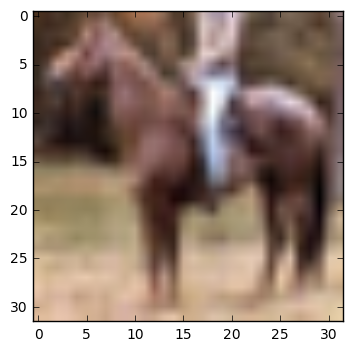

In [5]:
#temp = train[0, :].reshape([-1, 3, 32, 32]).transpose([0, 2, 3, 1])
#temp2 = convert_images(train[0,:])
#plt.figure(1)
#plt.imshow(temp[0])
#plt.figure(2)
#plt.imshow(temp2[0])

idx = 5000
temp = train.T[idx]
temp2 = temp.reshape([-1, 3, 32, 32]).transpose([0, 2, 3, 1])
print temp2.shape
plt.imshow(temp2[0, :, :, :])
print train_labels[idx]
print np.min(temp)


# Columns

In [ ]:
train_colMSEs = np.zeros(32)
test_colMSEs = np.zeros(32)
splitTest_colMSEs = np.zeros((32,5))
splitTest_means_col = np.zeros(32)
splitTest_stddevs_col = np.zeros(32)

for i in range(32):
    # define number of columns to remove
    nCols = i+1
    vecMask = generateColumnMask(nCols)

    # remove information
    train_hideRight, Xtrain_hideRight, Ytrain_hideRight, \
    test_hideRight, Xtest_hideRight, Ytest_hideRight = returnHalfData(nCols)

    # do mmse estimatoin
    u_x, u_y, cov_x, cov_yx = getStatistics(train, vecMask)
    Ytrain_hideRight_hat = mmseEstimator(Xtrain_hideRight, u_x, u_y, cov_x, cov_yx)
    Ytest_hideRight_hat = mmseEstimator(Xtest_hideRight, u_x, u_y, cov_x, cov_yx)

    # calculate mse per hidden pixel for train
    diff_train = Ytrain_hideRight - Ytrain_hideRight_hat
    numTrain = Ytrain_hideRight.shape[1]
    trainMSEs = np.zeros(numTrain)
    for j in range(numTrain):
        trainMSEs[j] = np.mean(np.multiply(diff_train[:, j], diff_train[:, j]))
    train_colMSEs[i] = np.mean(trainMSEs)

    # calculate mse per hidden pixel for test
    diff_test = Ytest_hideRight - Ytest_hideRight_hat
    numTest = Ytest_hideRight.shape[1]
    testMSEs = np.zeros(numTest)
    for j in range(numTest):
        testMSEs[j] = np.mean(np.multiply(diff_test[:, j], diff_test[:, j]))
    test_colMSEs[i] = np.mean(testMSEs)

    # Test data splits
    testSplit_Y_hat = np.zeros((5, Ytest_hideRight_hat.shape[0], Ytest_hideRight_hat.shape[1]/5))
    testSplit_Y = np.zeros((5, Ytest_hideRight.shape[0], Ytest_hideRight.shape[1]/5))

    for j in range(5):
        testSplit_Y[j, :, :] = Ytest_hideRight[:, j*2000:(j+1)*2000]
        testSplit_Y_hat[j, :, :] = Ytest_hideRight_hat[:, j*2000:(j+1)*2000]

    for j in range(5):
        diff_testSplit = testSplit_Y[j] - testSplit_Y_hat[j]
        splitTest_colMSEs[i][j] = np.mean(np.multiply(diff_testSplit, diff_testSplit))

    splitTest_means_col[i] = np.mean(splitTest_colMSEs[i])
    splitTest_stddevs_col[i] = np.std(splitTest_colMSEs[i])


In [ ]:
train_colMSEs_avgImage = np.zeros(32)
test_colMSEs_avgImage = np.zeros(32)
splitTest_colMSEs_avgImage = np.zeros((32,5))
splitTest_means_col_avgImage = np.zeros(32)
splitTest_stddevs_col_avgImage = np.zeros(32)

# -------------------------------------------------------------
#  Removing Different Number of Columns with average image
# -------------------------------------------------------------
avg_image = (np.mean(train, axis=1))
avg_image_packed = convert_images(avg_image)
plt.imshow(avg_image_packed[:, :, :, 0])

train_avgImage = np.tile(avg_image, (50000, 1)).T
test_avgImage = np.tile(avg_image, (10000, 1)).T

for i in range(33):
    # define number of columns to remove
    nCols = i+1
    vecMask = generateColumnMask(nCols)

    # remove information
    train_hideRight, Xtrain_hideRight, Ytrain_hideRight, \
    test_hideRight, Xtest_hideRight, Ytest_hideRight = returnHalfData(nCols)

    # portion out the avg image matrices
    temp1, temp2, Ytrain_hideRight_hat = hideData(train_avgImage, vecMask)
    temp1, temp2, Ytest_hideRight_hat = hideData(test_avgImage, vecMask)

    # calculate the mse per hidden pixel for train
    diff_train = Ytrain_hideRight - Ytrain_hideRight_hat
    numTrain = Ytrain_hideRight.shape[1]
    trainMSEs = np.zeros(numTrain)
    for j in range(numTrain):
        trainMSEs[j] = np.mean(np.multiply(diff_train[:, j], diff_train[:, j]))
    train_colMSEs_avgImage[i] = np.mean(trainMSEs)

    # calculate the mse per hidden pixel for test
    diff_test = Ytest_hideRight - Ytest_hideRight_hat
    numTest = Ytest_hideRight.shape[1]
    testMSEs = np.zeros(numTest)
    for j in range(numTest):
        testMSEs[j] = np.mean(np.multiply(diff_test[:, j], diff_test[:, j]))
    test_colMSEs_avgImage[i] = np.mean(testMSEs)

    
    # Test data splits
    testSplit_Y_hat = np.zeros((5, Ytest_hideRight_hat.shape[0], Ytest_hideRight_hat.shape[1]/5))
    testSplit_Y = np.zeros((5, Ytest_hideRight.shape[0], Ytest_hideRight.shape[1]/5))

    for j in range(5):
        testSplit_Y[j, :, :] = Ytest_hideRight[:, j*2000:(j+1)*2000]
        testSplit_Y_hat[j, :, :] = Ytest_hideRight_hat[:, j*2000:(j+1)*2000]

    for j in range(5):
        diff_testSplit = testSplit_Y[j] - testSplit_Y_hat[j]
        splitTest_colMSEs_avgImage[i][j] = np.mean(np.multiply(diff_testSplit, diff_testSplit))
    
    splitTest_means_col_avgImage[i] = np.mean(splitTest_colMSEs_avgImage[i])
    splitTest_stddevs_col_avgImage[i] = np.std(splitTest_colMSEs_avgImage[i])

In [ ]:
# plot mse 
plt.figure(1)
plt.plot(np.arange(1,33), train_colMSEs_avgImage, '-o', c='r')
plt.plot(np.arange(1,33), test_colMSEs_avgImage, '-o', c='b')
plt.errorbar(np.arange(1,33), test_colMSEs_avgImage, yerr=splitTest_stddevs_col_avgImage, linestyle='', c='b')

plt.plot(np.arange(1,33), train_colMSEs, '-o', c='g')
plt.plot(np.arange(1,33), test_colMSEs, '-o', c='c')
plt.errorbar(np.arange(1,33), test_colMSEs, yerr=splitTest_stddevs_col, linestyle='', c='b')

plt.title("Mean Square Estimator Error", fontsize=14)
plt.ylabel("Error", fontsize=14)
plt.xlabel("Hidden Columns", fontsize=14)
plt.show()

In [ ]:
#np.save('cifar_mmse_hideColumns_train.npy', train_colMSEs)
#np.save('cifar_mmse_hideColumns_testSplits.npy', splitTest_colMSEs)
#np.save('cifar_mmse_avgImage_hideColumns_train.npy', train_colMSEs_avgImage)
#np.save('cifar_mmse_avgImage_hideColumns_testSplits.npy', splitTest_colMSEs_avgImage)

In [6]:
# cached version of above calculations
# MSE generated results
train_mmse_removecols = np.load('%s/cifar_mmse_hideColumns_train.npy' %dataPath)
splitTest_mmse_removecols = np.load('%s/cifar_mmse_hideColumns_testSplits.npy' %dataPath)

test_mmse_means_removecols = np.zeros(32)
test_mmse_stddevs_removecols = np.zeros(32)
for i in range(32):
    test_mmse_means_removecols[i] = np.mean(splitTest_mmse_removecols[i])
    test_mmse_stddevs_removecols[i] = np.std(splitTest_mmse_removecols[i])

# random guessing of average training image
train_mmse_avgImage_removecols = np.load('%s/cifar_mmse_avgImage_hideColumns_train.npy' %dataPath)
splitTest_mmse_avgImage_removecols = np.load('%s/cifar_mmse_avgImage_hideColumns_testSplits.npy' %dataPath)

test_mmse_means_avgImage_removecols = np.zeros(32)
test_mmse_stddevs_avgImage_removecols = np.zeros(32)
for i in range(32):
    test_mmse_means_avgImage_removecols[i] = np.mean(splitTest_mmse_avgImage_removecols[i])
    test_mmse_stddevs_avgImage_removecols[i] = np.std(splitTest_mmse_avgImage_removecols[i])

print train_mmse_removecols[7]
print test_mmse_means_removecols[7]

0.0207637285661
0.0230181358785


In [7]:
# this incorporates neural network generated data
data_test_costs_columns = np.load('%s/cifar_data_test_costs_ncols.npy' %dataPath)
data_train_costs_columns = np.load('%s/cifar_data_train_costs_ncols.npy' %dataPath)
data_mses_testSplits_columns = np.load('%s/cifar_data_mses_testSplits_ncols.npy' %dataPath)

splitMeans_columns = np.zeros(8)
splitStddev_columns = np.zeros(8)
for i in range(8):
    splitMeans_columns[i] = np.mean(data_mses_testSplits_columns[i])
    splitStddev_columns[i] = np.std(data_mses_testSplits_columns[i])
    
print data_train_costs_columns

[ 0.01481332  0.02263923  0.02822195  0.03034606  0.03322252  0.03494389
  0.038071    0.06201001]


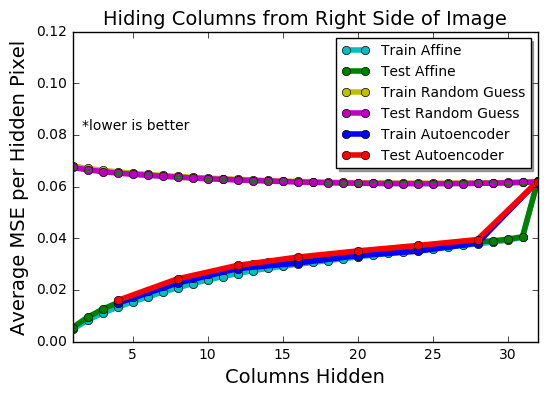

In [8]:
# plot test accuracy 
fig, ax = plt.subplots()
plt.figure(1)

numColsIdxs = np.arange(1,33)
numColsIdxs_autoencoder = np.arange(4, 36, 4)

plt.plot(numColsIdxs, train_mmse_removecols, '-o', c='c', label='Train Affine', linewidth=4.0)
plt.plot(numColsIdxs, test_mmse_means_removecols, '-o', c='g', label='Test Affine', linewidth=4.0)
plt.errorbar(numColsIdxs, test_mmse_means_removecols, yerr=test_mmse_stddevs_removecols, linestyle='', c='g', linewidth=4.0)

plt.plot(numColsIdxs, train_mmse_avgImage_removecols, '-o', c='y', label='Train Random Guess', linewidth=4.0)
plt.plot(numColsIdxs, test_mmse_means_avgImage_removecols, '-o', c='m', label='Test Random Guess', linewidth=4.0)
plt.errorbar(numColsIdxs, test_mmse_means_avgImage_removecols, yerr=test_mmse_stddevs_removecols, linestyle='', c='g', linewidth=4.0)

plt.plot(numColsIdxs_autoencoder, data_train_costs_columns, '-o', c='b', label='Train Autoencoder', linewidth=4.0)
plt.plot(numColsIdxs_autoencoder, splitMeans_columns, '-o', c='r', label='Test Autoencoder', linewidth=4.0)
plt.errorbar(numColsIdxs_autoencoder, splitMeans_columns, yerr=splitStddev_columns, linestyle='', c='r', linewidth=4.0)

legend = ax.legend(loc='best', shadow=True, fontsize=10)

plt.autoscale(enable=True, axis='x', tight=True)
plt.autoscale(enable=True, axis='y', tight=False)
plt.ylim([0,0.12])

ax.text(1.6, 0.082, '*lower is better', fontsize=10)

plt.title("Hiding Columns from Right Side of Image", fontsize=14)
plt.ylabel("Average MSE per Hidden Pixel", fontsize=14)
plt.xlabel("Columns Hidden", fontsize=14)
# plt.savefig('Fig_HideColumns_NewMSE.png')
plt.show()


# Squares

In [ ]:
train_squareMSEs = np.zeros(16)
test_squareMSEs = np.zeros(16)
splitTest_squareMSEs = np.zeros((16,5))
splitTest_means_square = np.zeros(16)
splitTest_stddevs_square = np.zeros(16)

for i in range(16):    
    # define number of columns to remove
    squareSideLength = (i+1)*2
    print "Iteration %d, Square Size: %d x %d" %(i, squareSideLength, squareSideLength)
    vecMask = generateCenterSquareMask(squareSideLength)

    # remove information
    train_hideCenter, Xtrain_hideCenter, Ytrain_hideCenter, \
    test_hideCenter, Xtest_hideCenter, Ytest_hideCenter = returnSquareData(squareSideLength)
    
    # do mmse estimatoin
    u_x, u_y, cov_x, cov_yx = getStatistics(train, vecMask)
    Ytrain_hideCenter_hat = mmseEstimator(Xtrain_hideCenter, u_x, u_y, cov_x, cov_yx)
    Ytest_hideCenter_hat = mmseEstimator(Xtest_hideCenter, u_x, u_y, cov_x, cov_yx)

    # calculate mse per hidden pixel for train
    diff_train = Ytrain_hideCenter - Ytrain_hideCenter_hat
    numTrain = Ytrain_hideCenter.shape[1]
    trainMSEs = np.zeros(numTrain)
    for j in range(numTrain):
        trainMSEs[j] = np.mean(np.multiply(diff_train[:, j], diff_train[:, j]))
    train_squareMSEs[i] = np.mean(trainMSEs)

    # calculate mse per hidden pixel for test
    diff_test = Ytest_hideCenter - Ytest_hideCenter_hat
    numTest = Ytest_hideCenter.shape[1]
    testMSEs = np.zeros(numTest)
    for j in range(numTest):
        testMSEs[j] = np.mean(np.multiply(diff_test[:, j], diff_test[:, j]))
    test_squareMSEs[i] = np.mean(testMSEs)

    # Test data splits
    testSplit_Y_hat = np.zeros((5, Ytest_hideCenter_hat.shape[0], Ytest_hideCenter_hat.shape[1]/5))
    testSplit_Y = np.zeros((5, Ytest_hideCenter.shape[0], Ytest_hideCenter.shape[1]/5))

    for j in range(5):
        testSplit_Y[j, :, :] = Ytest_hideCenter[:, j*2000:(j+1)*2000]
        testSplit_Y_hat[j, :, :] = Ytest_hideCenter_hat[:, j*2000:(j+1)*2000]

    for j in range(5):
        diff_testSplit = testSplit_Y[j] - testSplit_Y_hat[j]
        splitTest_squareMSEs[i][j] = np.mean(np.multiply(diff_testSplit, diff_testSplit))

    splitTest_means_square[i] = np.mean(splitTest_squareMSEs[i])
    splitTest_stddevs_square[i] = np.std(splitTest_squareMSEs[i])


In [ ]:
train_squareMSEs_avgImage = np.zeros(16)
test_squareMSEs_avgImage = np.zeros(16)
splitTest_squareMSEs_avgImage = np.zeros((16,5))
splitTest_means_square_avgImage = np.zeros(16)
splitTest_stddevs_square_avgImage = np.zeros(16)

# -------------------------------------------------------------
#  Removing Different Number of Columns with average image
# -------------------------------------------------------------
avg_image = (np.mean(train, axis=1))
avg_image_packed = convert_images(avg_image)
plt.imshow(avg_image_packed[:, :, :, 0])

train_avgImage = np.tile(avg_image, (50000, 1)).T
test_avgImage = np.tile(avg_image, (10000, 1)).T

for i in range(16):    
    # define number of columns to remove
    squareSideLength = (i+1)*2
    print "Iteration %d, Square Size: %d x %d" %(i, squareSideLength, squareSideLength)
    vecMask = generateCenterSquareMask(squareSideLength)

    # remove information
    train_hideCenter, Xtrain_hideCenter, Ytrain_hideCenter, \
    test_hideCenter, Xtest_hideCenter, Ytest_hideCenter = returnSquareData(squareSideLength)

    # portion out the avg image matrices
    temp1, temp2, Ytrain_hideCenter_hat = hideData(train_avgImage, vecMask)
    temp1, temp2, Ytest_hideCenter_hat = hideData(test_avgImage, vecMask)

    # calculate mse per hidden pixel for train
    diff_train = Ytrain_hideCenter - Ytrain_hideCenter_hat
    numTrain = Ytrain_hideCenter.shape[1]
    trainMSEs = np.zeros(numTrain)
    for j in range(numTrain):
        trainMSEs[j] = np.mean(np.multiply(diff_train[:, j], diff_train[:, j]))
    train_squareMSEs_avgImage[i] = np.mean(trainMSEs)

    # calculate mse per hidden pixel for test
    diff_test = Ytest_hideCenter - Ytest_hideCenter_hat
    numTest = Ytest_hideCenter.shape[1]
    testMSEs = np.zeros(numTest)
    for j in range(numTest):
        testMSEs[j] = np.mean(np.multiply(diff_test[:, j], diff_test[:, j]))
    test_squareMSEs_avgImage[i] = np.mean(testMSEs)

    # Test data splits
    testSplit_Y_hat = np.zeros((5, Ytest_hideCenter_hat.shape[0], Ytest_hideCenter_hat.shape[1]/5))
    testSplit_Y = np.zeros((5, Ytest_hideCenter.shape[0], Ytest_hideCenter.shape[1]/5))

    for j in range(5):
        testSplit_Y[j, :, :] = Ytest_hideCenter[:, j*2000:(j+1)*2000]
        testSplit_Y_hat[j, :, :] = Ytest_hideCenter_hat[:, j*2000:(j+1)*2000]

    for j in range(5):
        diff_testSplit = testSplit_Y[j] - testSplit_Y_hat[j]
        splitTest_squareMSEs_avgImage[i][j] = np.mean(np.multiply(diff_testSplit, diff_testSplit))

    splitTest_means_square_avgImage[i] = np.mean(splitTest_squareMSEs_avgImage[i])
    splitTest_stddevs_square_avgImage[i] = np.std(splitTest_squareMSEs_avgImage[i])

In [ ]:
# np.save('cifar_mmse_hideSquare_train.npy', train_squareMSEs)
# np.save('cifar_mmse_hideSquare_testSplits.npy', splitTest_squareMSEs)
# np.save('cifar_mmse_avgImage_hideSquare_train.npy', train_squareMSEs_avgImage)
# np.save('cifar_mmse_avgImage_hideSquare_testSplits.npy', splitTest_squareMSEs_avgImage)

In [9]:
# cached version of above calculations
# MSE generated results
train_mmse_removeSquares = np.load('%s/cifar_mmse_hideSquare_train.npy' %dataPath)
splitTest_mmse_removeSquares = np.load('%s/cifar_mmse_hideSquare_testSplits.npy' %dataPath)

test_mmse_means_removeSquares = np.zeros(16)
test_mmse_stddevs_removeSquares = np.zeros(16)
for i in range(16):
    test_mmse_means_removeSquares[i] = np.mean(splitTest_mmse_removeSquares[i])
    test_mmse_stddevs_removeSquares[i] = np.std(splitTest_mmse_removeSquares[i])

# random guessing of average training image
train_mmse_avgImage_removeSquares = np.load('%s/cifar_mmse_avgImage_hideSquare_train.npy' %dataPath)
splitTest_mmse_avgImage_removeSquares = np.load('%s/cifar_mmse_avgImage_hideSquare_testSplits.npy' %dataPath)

test_mmse_means_avgImage_removeSquares = np.zeros(16)
test_mmse_stddevs_avgImage_removeSquares = np.zeros(16)
for i in range(16):
    test_mmse_means_avgImage_removeSquares[i] = np.mean(splitTest_mmse_avgImage_removeSquares[i])
    test_mmse_stddevs_avgImage_removeSquares[i] = np.std(splitTest_mmse_avgImage_removeSquares[i])

print train_mmse_removeSquares[7]
print test_mmse_means_removeSquares[7]

0.0238071298273
0.026703076841


In [10]:
# this incorporates neural network generated data
data_test_costs_squares = np.load('%s/cifar_data_test_costs_square.npy' %dataPath)
data_train_costs_squares = np.load('%s/cifar_data_train_costs_square.npy' %dataPath)
data_mses_testSplits_squares = np.load('%s/cifar_data_mses_testSplits_square.npy' %dataPath)

splitMeans_squares = np.zeros(7)
splitStddev_squares = np.zeros(7)
for i in range(7):
    splitMeans_squares[i] = np.mean(data_mses_testSplits_squares[i])
    splitStddev_squares[i] = np.std(data_mses_testSplits_squares[i])
    
print data_train_costs_squares
print splitMeans_squares

[ 0.01669574  0.02172887  0.02581864  0.02853167  0.03056448  0.03264628
  0.06200918]
[ 0.01769332  0.02330158  0.02789051  0.03043217  0.03213225  0.03447741
  0.0618047 ]


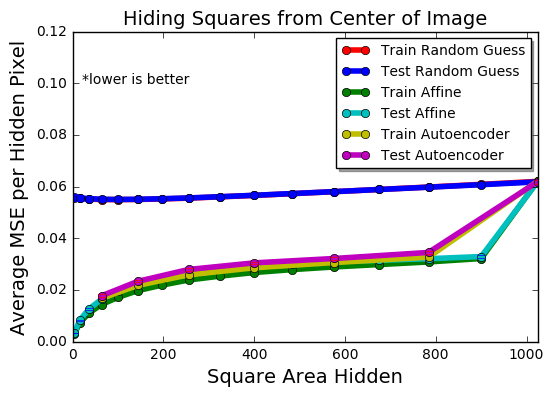

In [11]:
# plot mse 
fig, ax = plt.subplots()
plt.figure(1)
x_sideLengths = np.arange(2, 34, 2)
x_areas = np.multiply(x_sideLengths, x_sideLengths)

x_nn_sideLengths = np.arange(8, 36, 4)
x_nn_areas = np.multiply(x_nn_sideLengths, x_nn_sideLengths)

plt.plot(x_areas, train_mmse_avgImage_removeSquares, '-o', label='Train Random Guess', c='r', linewidth=4.0)
plt.plot(x_areas, test_mmse_means_avgImage_removeSquares, '-o', label='Test Random Guess', c='b', linewidth=4.0)
plt.errorbar(x_areas, test_mmse_means_avgImage_removeSquares, yerr=test_mmse_stddevs_avgImage_removeSquares, linestyle='', c='b', linewidth=4.0)

plt.plot(x_areas, train_mmse_removeSquares, '-o', label='Train Affine', c='g', linewidth=4.0)
plt.plot(x_areas, test_mmse_means_removeSquares, '-o', label='Test Affine', c='c', linewidth=4.0)
plt.errorbar(x_areas, test_mmse_means_removeSquares, yerr=test_mmse_stddevs_removeSquares, linestyle='', c='b', linewidth=4.0)

plt.plot(x_nn_areas, data_train_costs_squares, '-o', c='y', label='Train Autoencoder', linewidth=4.0)
plt.plot(x_nn_areas, splitMeans_squares, '-o', c='m', label='Test Autoencoder', linewidth=4.0)
plt.errorbar(x_nn_areas, splitMeans_squares, yerr=splitStddev_squares, linestyle='', c='r', linewidth=4.0)


legend = ax.legend(loc='best', shadow=True, fontsize=10)

plt.ylim([0,0.12])
plt.xlim([0,1024])

ax.text(20, 0.1, '*lower is better', fontsize=10)

plt.title("Hiding Squares from Center of Image", fontsize=14)
plt.ylabel("Average MSE per Hidden Pixel", fontsize=14)
plt.xlabel("Square Area Hidden", fontsize=14)
# plt.savefig('cifar_squares.png')
plt.show()